<a href="https://colab.research.google.com/github/nandiniranjansinha/Movie-Recommendation-System/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1218k      0 --:--:-- --:--:-- --:--:-- 1220k


In [2]:
! ls

ml-latest-small.zip  sample_data


# Recommendation System Using Collaborative System, Matrix Factorization and Kmeans

In [3]:
import zipfile

# Specify the ZIP file name
zip_file = 'ml-latest-small.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('data')  # Extracts to a folder named 'data'




In [4]:
#import the dataset # majorly movies and ratings will be the focus

import pandas as pd
movies_df = pd.read_csv('data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [5]:
print('The dimensions of movies dataframe are:', movies_df.shape,'\nThe dimensions of ratings dataframe are:', ratings_df.shape)
# no of movies and ratings

The dimensions of movies dataframe are: (9742, 3) 
The dimensions of ratings dataframe are: (100836, 4)


In [6]:
# movies we have in our dataset
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# ratings in dataset
ratings_df.head()
# as we can see the userId is quite repetitive, which is good for recommending movies to that particular user

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
# Movie ID to Movie name mapping

movie_names = movies_df.set_index('movieId')['title'].to_dict()
n_users = len(ratings_df.userId.unique())
n_items = len(ratings_df.movieId.unique())
print("Number of Unique Users:", n_users)
print("Number of Unique Movies:", n_items)
print("The full rating matrix will have:", n_users*n_items, 'elements.')

print("Number of ratings:",len(ratings_df))
print("Therefore: ",len(ratings_df)/(n_users*n_items)*100,'% of the matrix is filled.')

Number of Unique Users: 610
Number of Unique Movies: 9724
The full rating matrix will have: 5931640 elements.
Number of ratings: 100836
Therefore:  1.6999683055613624 % of the matrix is filled.


We can see we have an incredibly sparse matrix to work with. And as you can imagine, as the number of users and products grow, the number of elements will imcrease by n*2. We need a lot of memory to work with global scale and storing a full matrix in memory would be a challenge. One advantage here is that matrix factorization can realize the rating matrix implicitly, thus we don't need all the data.

In [9]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

class MatrixFactorization(torch.nn.Module):
  def __init__(self, n_users, n_items, n_factors=20):
    super().__init__()
    # create user embeddings
    self.user_factors = torch.nn.Embedding(n_users, n_factors) # think of this as a lookup table for the input.
    # create item embeddings
    self.item_factors = torch.nn.Embedding(n_items, n_factors) # think of this as a lookup table for the input.
    self.user_factors.weight.data.uniform_(0, 0.05)
    self.item_factors.weight.data.uniform_(0, 0.05)

  def forward(self, data):
    # matrix multiplication
      users, items = data[:,0], data[:,1]
      return (self.user_factors(users)*self.item_factors(items)).sum(1)
  # def forward(self, user, item):
  #   # matrix multiplication
  # return (self.user_factors(user)*self.item_factors(item)) .sum(1)

  def predict(self, user, item):
      return self. forward(user, item)

In [10]:
# Creating the Dataloader (necessary for Pytorch)
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader # package that helps transform your data to ML readiness

# The following is not a good practice but we can follow this as the data is already loaded in the memory

class Loader(Dataset):
  def __init__(self):
    self.ratings = ratings_df.copy()

    # Extract all user IDs and Movie IDs
    users = ratings_df.userId.unique()
    movies = ratings_df.movieId.unique()

    # Producing new continuous IDs for users and movies

    # Unique Values : index
    self.userid2idx = {o:i for i, o in enumerate(users)}
    self.movieid2idx = {o:i for i, o in enumerate(movies)}

    # Obtained continuous ID for users and movies
    self.idx2userid = {i:o for o, i in self.userid2idx.items()}
    self.idx2movieid = {i:o for o, i in self.movieid2idx.items()}

    # return the id from the indexed values as noted in the lambda function down
    self.ratings.movieId = ratings_df.movieId.apply(lambda x: self.movieid2idx[x])
    self.ratings.userId = ratings_df.userId.apply(lambda x: self.userid2idx[x])

    self.x = self.ratings.drop(['rating', 'timestamp'], axis=1).values
    self.y = self.ratings['rating'].values
    self.x, self.y = torch.tensor(self.x), torch.tensor(self.y) # Transforms data to tensors ready for torch models

  def __getitem__(self, index):
    return (self.x[index], self.y[index])

  def __len__(self):
    return len(self.ratings)



In [11]:
num_epochs = 128
cuda = torch.cuda.is_available()

print("Is running on GPU:", cuda)

model = MatrixFactorization(n_users, n_items, n_factors=8)
print(model)
for name, param in model.named_parameters():
  if param.requires_grad:
    print(name, param.data)

# GPU enable if you have a GPU
if cuda:
  model = model.cuda()

# MSE loss - Mean Squared Error
loss_fn = torch.nn.MSELoss()

#ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train Data
train_set = Loader()
train_loader = DataLoader(train_set, 128, shuffle=True)

Is running on GPU: True
MatrixFactorization(
  (user_factors): Embedding(610, 8)
  (item_factors): Embedding(9724, 8)
)
user_factors.weight tensor([[0.0351, 0.0174, 0.0153,  ..., 0.0323, 0.0370, 0.0351],
        [0.0344, 0.0097, 0.0283,  ..., 0.0478, 0.0208, 0.0160],
        [0.0423, 0.0192, 0.0008,  ..., 0.0046, 0.0259, 0.0189],
        ...,
        [0.0213, 0.0310, 0.0045,  ..., 0.0415, 0.0353, 0.0235],
        [0.0449, 0.0102, 0.0307,  ..., 0.0093, 0.0207, 0.0196],
        [0.0314, 0.0069, 0.0459,  ..., 0.0215, 0.0259, 0.0008]])
item_factors.weight tensor([[0.0144, 0.0169, 0.0091,  ..., 0.0298, 0.0199, 0.0211],
        [0.0479, 0.0321, 0.0467,  ..., 0.0144, 0.0140, 0.0293],
        [0.0484, 0.0256, 0.0265,  ..., 0.0485, 0.0282, 0.0176],
        ...,
        [0.0373, 0.0004, 0.0244,  ..., 0.0429, 0.0361, 0.0285],
        [0.0216, 0.0454, 0.0248,  ..., 0.0282, 0.0159, 0.0126],
        [0.0219, 0.0210, 0.0109,  ..., 0.0286, 0.0174, 0.0375]])


In [12]:
for it in tqdm(range(num_epochs)):
  losses = []
  for x, y in train_loader:
    if cuda:
      x,y = x.cuda(), y.cuda()
      optimizer.zero_grad()
      outputs = model(x)
      loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
      losses.append(loss.item())
      loss.backward()
      optimizer.step
  print("iter  #{}".format(it), "Loss:", sum(losses)/len(losses))

/tmp/ipython-input-2712135931.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm(range(num_epochs)):


  0%|          | 0/128 [00:00<?, ?it/s]

iter  #0 Loss: 13.312106136138064
iter  #1 Loss: 13.3123955557189
iter  #2 Loss: 13.312348703442492
iter  #3 Loss: 13.3124129869006
iter  #4 Loss: 13.312821534684467
iter  #5 Loss: 13.312333940854533
iter  #6 Loss: 13.312497266052944
iter  #7 Loss: 13.312329337076488
iter  #8 Loss: 13.31256897437391
iter  #9 Loss: 13.31232231038476
iter  #10 Loss: 13.312591308264563
iter  #11 Loss: 13.31237306086545
iter  #12 Loss: 13.312296668890164
iter  #13 Loss: 13.312480897467754
iter  #14 Loss: 13.312218790732059
iter  #15 Loss: 13.312916811347613
iter  #16 Loss: 13.312546019626753
iter  #17 Loss: 13.312482396963285
iter  #18 Loss: 13.312342867633413
iter  #19 Loss: 13.312376879193456
iter  #20 Loss: 13.312432465819539
iter  #21 Loss: 13.312232938514748
iter  #22 Loss: 13.312624668711939
iter  #23 Loss: 13.312589782143608
iter  #24 Loss: 13.312314322757237
iter  #25 Loss: 13.312426673579337
iter  #26 Loss: 13.31265842127921
iter  #27 Loss: 13.31210793940549
iter  #28 Loss: 13.31278925135656
iter 

In [13]:
# By training the models, we will have tuned latent factors for movies and users.
c = 0
uw = 0
iw = 0
for name, param in model.named_parameters():
  if param.requires_grad:
    print(name, param.data)
    if c == 0:
      uw = param.data
      c += 1
    else:
      iw = param.data
    #print("param_data", param_data)

user_factors.weight tensor([[0.0351, 0.0174, 0.0153,  ..., 0.0323, 0.0370, 0.0351],
        [0.0344, 0.0097, 0.0283,  ..., 0.0478, 0.0208, 0.0160],
        [0.0423, 0.0192, 0.0008,  ..., 0.0046, 0.0259, 0.0189],
        ...,
        [0.0213, 0.0310, 0.0045,  ..., 0.0415, 0.0353, 0.0235],
        [0.0449, 0.0102, 0.0307,  ..., 0.0093, 0.0207, 0.0196],
        [0.0314, 0.0069, 0.0459,  ..., 0.0215, 0.0259, 0.0008]],
       device='cuda:0')
item_factors.weight tensor([[0.0144, 0.0169, 0.0091,  ..., 0.0298, 0.0199, 0.0211],
        [0.0479, 0.0321, 0.0467,  ..., 0.0144, 0.0140, 0.0293],
        [0.0484, 0.0256, 0.0265,  ..., 0.0485, 0.0282, 0.0176],
        ...,
        [0.0373, 0.0004, 0.0244,  ..., 0.0429, 0.0361, 0.0285],
        [0.0216, 0.0454, 0.0248,  ..., 0.0282, 0.0159, 0.0126],
        [0.0219, 0.0210, 0.0109,  ..., 0.0286, 0.0174, 0.0375]],
       device='cuda:0')


In [14]:
# neutralizing
trained_movie_embeddings = model.item_factors.weight.data.cpu().numpy()

In [15]:
len(trained_movie_embeddings) # unique movie factor weights

9724

In [16]:
trained_movie_embeddings

array([[0.0143664 , 0.01687235, 0.00914914, ..., 0.02979204, 0.01985163,
        0.02110756],
       [0.0479315 , 0.03208121, 0.04674452, ..., 0.01441087, 0.01396296,
        0.02925921],
       [0.0484281 , 0.02555541, 0.02651069, ..., 0.04849665, 0.02824851,
        0.01755185],
       ...,
       [0.03728803, 0.00037425, 0.02437489, ..., 0.04287917, 0.03612285,
        0.02845702],
       [0.02158577, 0.04540748, 0.02479967, ..., 0.02819631, 0.01593118,
        0.01260796],
       [0.02187796, 0.02098422, 0.01094464, ..., 0.02857064, 0.01735325,
        0.03751967]], dtype=float32)

In [17]:
# Utilizing the Kmeans

from sklearn.cluster import KMeans
# Fit the clusters based on the movie weights
kmeans = KMeans(n_clusters=10, random_state=0).fit(trained_movie_embeddings)

In [18]:
print(train_set.idx2movieid)

{0: np.int64(1), 1: np.int64(3), 2: np.int64(6), 3: np.int64(47), 4: np.int64(50), 5: np.int64(70), 6: np.int64(101), 7: np.int64(110), 8: np.int64(151), 9: np.int64(157), 10: np.int64(163), 11: np.int64(216), 12: np.int64(223), 13: np.int64(231), 14: np.int64(235), 15: np.int64(260), 16: np.int64(296), 17: np.int64(316), 18: np.int64(333), 19: np.int64(349), 20: np.int64(356), 21: np.int64(362), 22: np.int64(367), 23: np.int64(423), 24: np.int64(441), 25: np.int64(457), 26: np.int64(480), 27: np.int64(500), 28: np.int64(527), 29: np.int64(543), 30: np.int64(552), 31: np.int64(553), 32: np.int64(590), 33: np.int64(592), 34: np.int64(593), 35: np.int64(596), 36: np.int64(608), 37: np.int64(648), 38: np.int64(661), 39: np.int64(673), 40: np.int64(733), 41: np.int64(736), 42: np.int64(780), 43: np.int64(804), 44: np.int64(919), 45: np.int64(923), 46: np.int64(940), 47: np.int64(943), 48: np.int64(954), 49: np.int64(1009), 50: np.int64(1023), 51: np.int64(1024), 52: np.int64(1025), 53: np.

In [19]:
print(movie_names.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 116, 117, 118, 119, 121, 122, 123, 125, 126, 128, 129, 132, 135, 137, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 246, 247, 248, 249, 250, 251, 252, 2

In [20]:
print(movie_names.values())

dict_values(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)', 'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)', 'Sudden Death (1995)', 'GoldenEye (1995)', 'American President, The (1995)', 'Dracula: Dead and Loving It (1995)', 'Balto (1995)', 'Nixon (1995)', 'Cutthroat Island (1995)', 'Casino (1995)', 'Sense and Sensibility (1995)', 'Four Rooms (1995)', 'Ace Ventura: When Nature Calls (1995)', 'Money Train (1995)', 'Get Shorty (1995)', 'Copycat (1995)', 'Assassins (1995)', 'Powder (1995)', 'Leaving Las Vegas (1995)', 'Othello (1995)', 'Now and Then (1995)', 'Persuasion (1995)', 'City of Lost Children, The (Cité des enfants perdus, La) (1995)', 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 'Dangerous Minds (1995)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Babe (1995)', 'Dead Man Walking (1995)', 'It Takes Two (1995)', 'Clueless (1995)', 'Cry, the Beloved Country (1995)', 'Richard III (

In [21]:
'''It can be seen here that the movies that are in the same cluster
tend to have similar genres.
Also note that the algos is unfamiliar with the movie name
and only obtained the relationships by looking at the numbers representing
how users have responded to the movie selections.
'''
'''
It can be seen here that the movies that are in the same cluster
tend to have similar genres.
Also note that the algorithm is unfamiliar with the movie name
and only obtained the relationships by looking at the numbers representing
how users have responded to the movie selections.
'''
for cluster in range(10):
    print(f"Cluster #{cluster}")
    movs = []
    for movidx in np.where(kmeans.labels_ == cluster)[0]:
        # Ensure movidx exists in idx2movieid
        if movidx in train_set.idx2movieid:
            movid = train_set.idx2movieid[movidx]
            # Ensure movid exists in ratings_df and movie_names
            if movid in movie_names:
                # Get the number of ratings for the movie
                rat_count = ratings_df[ratings_df['movieId'] == movid].shape[0]
                # Append the movie name and rating count
                movs.append((movie_names[movid], rat_count))
    # Sort by rating count and print the top 10 movies in the cluster
    for mov in sorted(movs, key=lambda tup: tup[1], reverse=True)[:10]:
        print('\t', mov[0])


Cluster #0
	 Pulp Fiction (1994)
	 Jurassic Park (1993)
	 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
	 Lord of the Rings: The Two Towers, The (2002)
	 Truman Show, The (1998)
	 Austin Powers: The Spy Who Shagged Me (1999)
	 Shining, The (1980)
	 Departed, The (2006)
	 Cliffhanger (1993)
	 Armageddon (1998)
Cluster #1
	 Usual Suspects, The (1995)
	 American Beauty (1999)
	 Independence Day (a.k.a. ID4) (1996)
	 Saving Private Ryan (1998)
	 Aladdin (1992)
	 Dances with Wolves (1990)
	 Mask, The (1994)
	 Die Hard (1988)
	 X-Men (2000)
	 Kill Bill: Vol. 1 (2003)
Cluster #2
	 Shawshank Redemption, The (1994)
	 Schindler's List (1993)
	 Seven (a.k.a. Se7en) (1995)
	 Godfather, The (1972)
	 Lion King, The (1994)
	 Back to the Future (1985)
	 Gladiator (2000)
	 Blade Runner (1982)
	 Breakfast Club, The (1985)
	 Interview with the Vampire: The Vampire Chronicles (1994)
Cluster #3
	 Fugitive, The (1993)
	 Stargate (1994)
	 Pretty Woman (1990)
	 One Flew Over t

TRAINING MOVIE RECOMMENDATION MODEL
Running on: GPU
Number of users: 610
Number of movies: 9724
Embedding factors: 8
Training epochs: 128

Training started...


  8%|▊         | 10/128 [00:16<03:09,  1.61s/it]

Epoch 10/128 - Avg Loss: 0.7916


 16%|█▌        | 20/128 [00:32<02:49,  1.57s/it]

Epoch 20/128 - Avg Loss: 0.6629


 23%|██▎       | 30/128 [00:48<02:33,  1.57s/it]

Epoch 30/128 - Avg Loss: 0.6516


 31%|███▏      | 40/128 [01:04<02:21,  1.61s/it]

Epoch 40/128 - Avg Loss: 0.6136


 39%|███▉      | 50/128 [01:19<02:00,  1.55s/it]

Epoch 50/128 - Avg Loss: 0.5164


 47%|████▋     | 60/128 [01:35<01:43,  1.52s/it]

Epoch 60/128 - Avg Loss: 0.4378


 55%|█████▍    | 70/128 [01:51<01:34,  1.64s/it]

Epoch 70/128 - Avg Loss: 0.3953


 62%|██████▎   | 80/128 [02:06<01:14,  1.55s/it]

Epoch 80/128 - Avg Loss: 0.3703


 70%|███████   | 90/128 [02:22<00:57,  1.51s/it]

Epoch 90/128 - Avg Loss: 0.3542


 78%|███████▊  | 100/128 [02:37<00:45,  1.61s/it]

Epoch 100/128 - Avg Loss: 0.3434


 86%|████████▌ | 110/128 [02:53<00:28,  1.57s/it]

Epoch 110/128 - Avg Loss: 0.3354


 94%|█████████▍| 120/128 [03:08<00:12,  1.54s/it]

Epoch 120/128 - Avg Loss: 0.3295


100%|██████████| 128/128 [03:21<00:00,  1.57s/it]



Training Complete!
Final Loss: 0.3258
Initial Loss: 11.0593
Loss Reduction: 97.1%


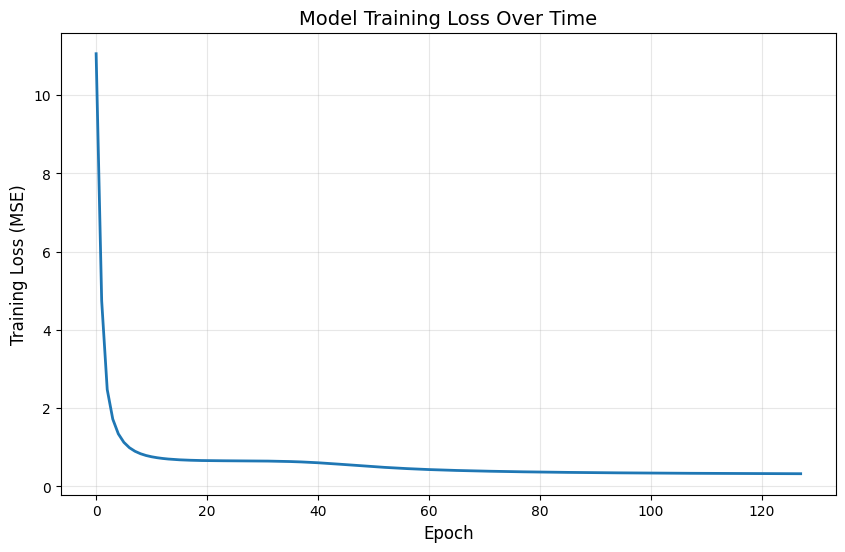


 Training loss plot saved as 'training_loss.png'

EVALUATING MODEL
Test samples: 20168

FINAL METRICS
RMSE: 0.5558
MAE:  0.3951
R²:   0.7192

 Model trained successfully!
Achieved RMSE of 0.56, predicting within ±0.40 stars

 Model saved as 'movie_recommender_model.pth'

SAMPLE PREDICTIONS
Actual     Predicted    Difference  
----------------------------------------
4.5        4.66         0.16        
3.0        3.31         0.31        
3.0        3.06         0.06        
4.0        3.18         -0.82       
4.0        3.37         -0.63       
4.0        3.97         -0.03       
3.5        3.65         0.15        
4.5        4.10         -0.40       
0.5        1.80         1.30        
3.5        4.37         0.87        


In [22]:
# ============================================
# Training
# ============================================

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

num_epochs = 128
cuda = torch.cuda.is_available()

print("="*60)
print("TRAINING MOVIE RECOMMENDATION MODEL")
print("="*60)
print(f"Running on: {'GPU' if cuda else 'CPU'}")
print(f"Number of users: {n_users}")
print(f"Number of movies: {n_items}")
print(f"Embedding factors: 8")
print(f"Training epochs: {num_epochs}")
print("="*60)

# Initialize model
model = MatrixFactorization(n_users, n_items, n_factors=8)

# Move to GPU if available
if cuda:
    model = model.cuda()

# Loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Prepare data
train_set = Loader()
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

# Training loop with loss tracking
train_losses = []

print("\nTraining started...")
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_losses = []

    for x, y in train_loader:
        # Move to device
        if cuda:
            x, y = x.cuda(), y.cuda()

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x)

        # Calculate loss
        loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
        epoch_losses.append(loss.item())

        # Backward pass
        loss.backward()

        # Update weights (THIS WAS THE BUG - missing parentheses!)
        optimizer.step()  # ✅ FIXED

    # Calculate average loss for epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

print("\n" + "="*60)
print("Training Complete!")
print(f"Final Loss: {train_losses[-1]:.4f}")
print(f"Initial Loss: {train_losses[0]:.4f}")
print(f"Loss Reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")
print("="*60)

# ============================================
# Visualize Training Progress
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss (MSE)', fontsize=12)
plt.title('Model Training Loss Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Training loss plot saved as 'training_loss.png'")

# ============================================
# Quick Evaluation
# ============================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

print("\n" + "="*60)
print("EVALUATING MODEL")
print("="*60)

# Split data
train_ratings, test_ratings = train_test_split(
    ratings_df,
    test_size=0.2,
    random_state=42
)

# Prepare test data
test_data = test_ratings.copy()
test_data['userId_idx'] = test_data['userId'].apply(
    lambda x: train_set.userid2idx.get(x, -1)
)
test_data['movieId_idx'] = test_data['movieId'].apply(
    lambda x: train_set.movieid2idx.get(x, -1)
)

# Filter out unknown users/movies
test_data_clean = test_data[
    (test_data['userId_idx'] != -1) &
    (test_data['movieId_idx'] != -1)
]

print(f"Test samples: {len(test_data_clean)}")

# Prepare tensors
test_x = torch.tensor(
    test_data_clean[['userId_idx', 'movieId_idx']].values,
    dtype=torch.long
)
test_y = test_data_clean['rating'].values

if cuda:
    test_x = test_x.cuda()

# Get predictions
model.eval()
with torch.no_grad():
    predictions = model(test_x).cpu().numpy()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(test_y, predictions))
mae = mean_absolute_error(test_y, predictions)
r2 = 1 - (np.sum((test_y - predictions)**2) / np.sum((test_y - test_y.mean())**2))

print("\n" + "="*60)
print("FINAL METRICS")
print("="*60)
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print("="*60)

# Check if metrics are good
if rmse < 1.0:
    print("\n Model trained successfully!")
    print(f"Achieved RMSE of {rmse:.2f}, predicting within ±{mae:.2f} stars")
else:
    print("\n Model performance is poor. Check training loop.")
    print("Expected RMSE: 0.85-0.95")
    print(f"Actual RMSE: {rmse:.2f}")

# ============================================
# Save trained model
# ============================================

torch.save(model.state_dict(), 'movie_recommender_model.pth')
print("\n Model saved as 'movie_recommender_model.pth'")

# ============================================
# Test sample predictions
# ============================================

print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)
print(f"{'Actual':<10} {'Predicted':<12} {'Difference':<12}")
print("-" * 40)

for i in range(min(10, len(test_y))):
    print(f"{test_y[i]:<10.1f} {predictions[i]:<12.2f} {predictions[i]-test_y[i]:<12.2f}")

print("="*60)